In [2]:
import warnings
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn, config_context
patch_sklearn()
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# custom functions
import config
from utils import DataConnector
from metric import NMAE
from data_processor import *

# model import
import xgboost as xgb
from xgboost import XGBRegressor

# logging
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models import infer_signature

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


* dask transform -> 23.5s  
* train_test split (각 1년씩)
* 13.18975

# 2. Target 24h Shift + Simple Split

In [4]:
# SET MLFLOW CONFIG
target = config.target
data_name = "v3.1_(Add ideal power)" # data name
artifact_path = 'baseline_no_param' # model name
registered_model_name= 'tracking-test'

In [5]:
print(config.mlflow)

False


In [6]:
import os

path = '../input/'
files = os.listdir(path)

gj_scada = []
for f in files:
    if "ewp02" in f:
        gj_scada.append(f)

In [7]:
tmp = pd.DataFrame()
for name in gj_scada:
    scada = pd.read_parquet(config.input_path + name).rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id'})
    tmp = pd.concat([tmp, scada], axis=0)

idx = tmp.loc[tmp['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
tmp.drop(idx, axis=0, inplace=True)

try:
    tmp['dt'] = (pd.to_datetime(tmp['dt'])
                 .dt
                 .tz_convert("Asia/Seoul"))
    
except TypeError:
    tmp['dt'] = (pd.to_datetime(tmp['dt'])
                 .dt
                 .tz_localize("Asia/Seoul"))

In [8]:
# get data
train_y, ldaps = DataConnector().get_data(start_date='2020-01-01',
                                        end_date='2023-01-01',
                                        plant_name='경주풍력')

new_train_y = pd.read_parquet("../input/gj_train_y.parquet")

# build data pipeline
print('-' * 50)
print('Feature Engineering')

DataPipeline = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, 100, ldaps['surf_rough'].mean())),
    ('dt_to_dtfeatures', DatetimeTransformer('gj', encoding=False)),
    ('feature_engineering', FeatureTransformer()),
    ('timelag_transform', TimeLagTransformer([1, 3, 6, 12], rolling=False)),
])

# data transform
ldaps = DataPipeline.fit_transform(ldaps)

--------------------------------------------------
Feature Engineering


In [63]:
preds = []
for i in range(1, 10):

    temp = pd.merge(ldaps[ldaps['turbine_id'] == f'WTG0{i}'], train_y[['dt', 'energy_kwh']], on='dt')

    # Split train valid
    print('-' * 50)
    print("Train Test Split")
    temp = temp.drop(['turbine_id'], axis=1)

    # 24h shift
    temp['target'] = temp['energy_kwh'].shift(periods=-24)
    temp = temp.dropna(subset=['energy_kwh'], axis=0)

    temp.drop([f'energy_kwh'], axis=1, inplace=True)

    train = temp.loc[temp['dt'].between('2020-01-01', '2021-08-01', inclusive='left')].drop(['dt'], axis=1)
    test = temp.loc[temp['dt'].between('2021-08-01', '2022-01-01', inclusive='left')].drop(['dt'], axis=1)

    x_train, x_test = train.drop('target', axis=1), test.drop('target', axis=1)
    y_train, y_test = train['target'], test['target']

    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    # Train model
    print('-' * 50)
    print("Train Model")
    model = XGBRegressor(random_state=1,
                        n_jobs=-1,
                        device='cuda',
                        objective='reg:absoluteerror',
                        eval_metric='mae')

    model.fit(x_train, y_train)

    # predict
    y_pred = model.predict(x_test)
    preds.append(y_pred)

    # Scoring
    print("NMAE: ", NMAE(y_test, y_pred, 20700))
    gc.collect();

--------------------------------------------------
Train Test Split
(13848, 45) (3671, 45) (13848,) (3671,)
--------------------------------------------------
Train Model
NMAE:  23.1424048319362
--------------------------------------------------
Train Test Split
(13848, 45) (3671, 45) (13848,) (3671,)
--------------------------------------------------
Train Model
NMAE:  21.933983331729394
--------------------------------------------------
Train Test Split
(13848, 45) (3671, 45) (13848,) (3671,)
--------------------------------------------------
Train Model
NMAE:  22.46298467606975
--------------------------------------------------
Train Test Split
(13848, 45) (3671, 45) (13848,) (3671,)
--------------------------------------------------
Train Model
NMAE:  22.61691707165472
--------------------------------------------------
Train Test Split
(13848, 45) (3671, 45) (13848,) (3671,)
--------------------------------------------------
Train Model
NMAE:  22.61691707165472
--------------------

In [67]:
NMAE(y_test, np.mean(preds, axis=0), 20700)

21.678857463040156

In [58]:
estimators = []
stack_train, stack_test = [], []

for i in range(1, 10):

    temp = pd.merge(ldaps[ldaps['turbine_id'] == f'WTG0{i}'], new_train_y[['dt', f'WTG{i}']], on='dt')

    # Split train valid
    print('-' * 50)
    print("Train Test Split")
    temp = temp.drop(['turbine_id'], axis=1)

    # 24h shift
    temp['target'] = temp[f'WTG{i}'].shift(periods=-24)
    temp = temp.dropna(subset=[f'WTG{i}'], axis=0)

    # temp = temp[temp[f'WTG{i}'] != 0]

    temp.drop([f'WTG{i}'], axis=1, inplace=True)

    train = temp.loc[temp['dt'].between('2020-01-01', '2021-08-01', inclusive='left')].drop(['dt'], axis=1)
    test = temp.loc[temp['dt'].between('2021-0-01', '2022-01-01', inclusive='left')].drop(['dt'], axis=1)

    x_train, x_test = train.drop('target', axis=1), test.drop('target', axis=1)
    y_train, y_test = train['target'], test['target']

    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    # Train model
    print('-' * 50)
    print("Train Model")
    model = XGBRegressor(random_state=1,
                        n_jobs=-1,
                        device='cuda',
                        objective='reg:absoluteerror',
                        eval_metric='mae')

    model.fit(x_train, y_train)

    # predict
    y_pred = model.predict(x_test)

    # Scoring
    print("NMAE: ", NMAE(y_test, y_pred, 2300))

    stack_train.append(model.predict(x_train))
    stack_test.append(model.predict(x_test))

    estimators.append(model)
    gc.collect();

--------------------------------------------------
Train Test Split


KeyError: 'WTG1'

In [38]:
df = temp.loc[temp['dt'].between('2021-01-01', '2022-01-01', inclusive='left'), 'dt']
pd.date_range(start = '2021-01-01 00:00:00', end = '2022-01-01 00:00:00' ).difference(df)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-01'],
              dtype='datetime64[ns]', length=366, freq='D')

In [53]:
test_dt = temp.loc[temp['dt'].between('2021-01-01', '2022-01-01', inclusive='left'), 'dt']

In [54]:
new_train_y.loc[new_train_y['dt'].isin(test_dt)]

,dt,WTG1,WTG2,WTG3,WTG4,WTG5,WTG6,WTG7,WTG8,WTG9,energy_kwh
8783,2021-01-01 00:00:00+09:00,1517.578125,2150.390625,2175.781250,0.000000,2267.578125,1531.250000,1023.437500,0.000000,2218.750000,17273.437500
8784,2021-01-01 01:00:00+09:00,1751.953125,2281.250000,2298.828125,2330.078125,2328.125000,1533.203125,1023.437500,2240.234375,2269.531250,18119.140625
8785,2021-01-01 02:00:00+09:00,1412.109375,2259.765625,2267.578125,2332.031250,2328.125000,1541.015625,1023.437500,2201.171875,2251.953125,17664.062500
8786,2021-01-01 03:00:00+09:00,1511.718750,2214.843750,2275.390625,2330.078125,2318.359375,1539.062500,1023.437500,2173.828125,2251.953125,17691.406250
8787,2021-01-01 04:00:00+09:00,2173.828125,2115.234375,126.953125,2322.265625,1451.171875,1533.203125,1027.343750,2253.906250,2269.531250,15314.453125
...,...,...,...,...,...,...,...,...,...,...,...
17538,2021-12-31 19:00:00+09:00,2080.078125,2130.859375,2259.765625,2244.140625,2257.812500,2269.531250,1558.593750,2205.078125,0.000000,14843.750000
17539,2021-12-31 20:00:00+09:00,2103.515625,2267.578125,2273.437500,2255.859375,2257.812500,2265.625000,675.781250,2261.718750,0.000000,14158.203125
17540,2021-12-31 21:00:00+09:00,2210.937500,2294.921875,2296.875000,2259.765625,2255.859375,2267.578125,2257.812500,2263.671875,0.000000,15902.343750
17541,2021-12-31 22:00:00+09:00,2183.593750,2257.812500,2236.328125,2238.281250,2201.171875,2246.093750,2251.953125,2246.093750,0.000000,15693.359375


In [55]:
final_train = new_train_y.loc[new_train_y['dt'].between('2020-01-02', '2021-01-01', inclusive='left')].drop(['dt'], axis=1)
final_test = new_train_y.loc[new_train_y['dt'].isin(test_dt)].drop(['dt'], axis=1)


#x_train_f, x_test_f = final_train.drop(['energy_kwh'], axis=1), final_test.drop(['energy_kwh'], axis=1)
x_train_f, x_test_f = np.transpose(np.array(stack_train)), np.transpose(np.array(stack_test))
y_train_f, y_test_f = final_train['energy_kwh'], final_test['energy_kwh']

print(x_train_f.shape, x_test_f.shape, y_train_f.shape, y_test_f.shape)

(8760, 9) (8759, 9) (8760,) (8759,)


In [57]:
from sklearn.ensemble import RandomForestRegressor

# 최종 모델 학습 (예: Linear Regression)
final_model = RandomForestRegressor()
final_model.fit(x_train_f, y_train_f)

# 스태킹 모델의 예측
final_preds = final_model.predict(x_test_f)

# 최종 NMAE 계산 및 출력
final_nmae = NMAE(y_test_f, final_preds)
print(f"Final Stacking Model NMAE: {final_nmae}")

Final Stacking Model NMAE: 22.682315336496764


In [18]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 각 터빈에 대한 개별 모델을 저장할 리스트와 예측값을 저장할 딕셔너리 초기화
estimators = []
trainset, preds = {}, {}
stack_train_X, stack_train_y = [], []
stack_test_X, stack_test_y = [], []

for i in range(1, 10):
    temp = pd.merge(ldaps[ldaps['turbine_id'] == f'WTG0{i}'], new_train_y[['dt', f'WTG{i}']], on='dt')

    # 데이터 전처리 및 Train-Test Split
    print('-' * 50)
    print("Train Test Split")
    temp = temp.drop(['turbine_id'], axis=1)

    # 24시간 shift하여 타겟 설정
    temp['target'] = temp[f'WTG{i}'].shift(periods=-24)
    temp = temp.dropna(axis=0)

    # 필요없는 열 제거
    temp.drop([f'WTG{i}'], axis=1, inplace=True)

    # Train/Valid Split
    train = temp.loc[temp['dt'].between('2020-01-01', '2021-01-01', inclusive='left')].drop(['dt'], axis=1)
    test = temp.loc[temp['dt'].between('2021-01-01', '2022-01-01', inclusive='left')].drop(['dt'], axis=1)

    x_train, x_test = train.drop('target', axis=1), test.drop('target', axis=1)
    y_train, y_test = train['target'], test['target']

    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    # 모델 학습
    print('-' * 50)
    print("Train Model")
    model = XGBRegressor(
        random_state=1,
        n_jobs=-1,
        device='cuda',
        objective='reg:absoluteerror',
        eval_metric='mae'
    )
    model.fit(x_train, y_train)
    estimators.append(model)

    # Train 데이터에 대한 예측을 수집하여 stack_train_X에 저장
    train_preds = model.predict(x_train)
    stack_train_X.append(train_preds)

    # Test 데이터에 대한 예측을 수집하여 stack_test_X에 저장
    test_preds = model.predict(x_test)
    stack_test_X.append(test_preds)

    # NMAE 계산 및 출력
    nmae = mean_absolute_error(y_test, test_preds) / 2300
    print(f"NMAE for WTG{i}: {nmae}")

# 스태킹을 위한 데이터 구성
stack_train_X = np.column_stack(stack_train_X)
stack_test_X = np.column_stack(stack_test_X)
stack_train_y = train_y.loc[train_y['dt'].between('2020-01-01', '2021-01-01', inclusive='left'), 'energy_kwh']
stack_test_y = train_y.loc[train_y['dt'].between('2021-01-01', '2022-01-01', inclusive='left'), 'energy_kwh']

# 최종 모델 학습 (예: Linear Regression)
final_model = LinearRegression()
final_model.fit(stack_train_X, stack_train_y)

# 스태킹 모델의 예측
final_preds = final_model.predict(stack_test_X)

# 최종 NMAE 계산 및 출력
final_nmae = mean_absolute_error(stack_test_y, final_preds) / 20700
print(f"Final Stacking Model NMAE: {final_nmae}")

--------------------------------------------------
Train Test Split
(8748, 45) (8759, 45) (8748,) (8759,)
--------------------------------------------------
Train Model
NMAE for WTG1: 0.2486185253301406
--------------------------------------------------
Train Test Split
(8760, 45) (8759, 45) (8760,) (8759,)
--------------------------------------------------
Train Model
NMAE for WTG2: 0.22871032239591446
--------------------------------------------------
Train Test Split
(8760, 45) (8759, 45) (8760,) (8759,)
--------------------------------------------------
Train Model
NMAE for WTG3: 0.23739574061549323
--------------------------------------------------
Train Test Split
(8760, 45) (8759, 45) (8760,) (8759,)
--------------------------------------------------
Train Model
NMAE for WTG4: 0.23026427696667012
--------------------------------------------------
Train Test Split
(8760, 45) (8759, 45) (8760,) (8759,)
--------------------------------------------------
Train Model
NMAE for WTG5: 0

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 8748 and the array at index 1 has size 8760

In [22]:
pd.DataFrame(stack_train_X).T

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,1188.223755,1754.858154,1463.802124,1299.331299,1296.466187,1117.975586,1436.312744,1898.928467,1923.786499,2211.232910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2317.118164,2270.932861,2264.962158,2269.984619,2272.644043,2273.093506,2273.652100,2277.242676,2285.491211,2268.774414,...,818.220947,915.874634,1033.096069,595.456482,183.848877,185.633392,162.092438,-103.485474,111.109192,420.593933
2,2270.987305,2267.989014,2107.162354,2267.109863,2269.482178,2272.277588,2317.754639,2270.658691,2315.596924,2270.627930,...,974.083435,1368.092651,1364.256226,712.755432,392.079742,502.982483,161.316742,144.411209,424.281769,671.036499
3,2323.905029,2328.712646,2333.220215,2276.060303,2330.010498,2332.744385,2340.866699,2331.967285,2329.214111,2351.336182,...,1109.984253,1075.565063,1336.926392,1089.905762,419.904877,278.553345,244.289368,330.020477,565.756958,775.398315
4,-12.540678,-34.397045,-21.772364,-4.707575,-2.976917,14.965760,104.674217,32.233910,3.296292,48.330162,...,711.487549,1270.050049,944.478149,632.397400,307.627777,402.552673,208.996048,162.623474,599.158508,808.835083
5,2298.376953,2177.777100,2299.786133,2306.750977,2345.739014,2301.067627,2324.643555,2290.307373,2691.567139,2305.395508,...,532.547241,1102.305420,770.520142,511.896851,552.118591,495.852814,418.707672,400.087036,926.291687,1014.116211
6,2368.395508,2368.825928,2344.183105,2388.790283,2328.109863,2243.220459,2236.660156,2312.119629,2227.443848,2337.513428,...,671.743042,1041.640747,892.757446,714.889038,758.518494,719.318115,637.939697,587.486938,1236.789429,1249.297729
7,2311.846191,2284.619385,2301.794434,2311.917480,2299.190430,2302.632812,2306.791260,2304.624756,2281.018311,2302.223877,...,494.396606,1193.592529,1144.972778,774.159119,794.306335,762.975403,519.398193,530.886963,1085.739746,979.687012
8,420.107117,518.461121,529.408997,986.565002,957.728943,697.834045,490.837036,37.858654,-8.968683,236.132889,...,870.948425,1743.461426,1550.989502,1029.840454,993.142639,920.853943,757.037598,633.948730,1335.743530,1308.879028


: 

# 정리
(WTG01)
* Simple Split: 13.189
* Target 24h Shift + Simple Split: 21.711 
* Time Series Split(5 Fold): 13.268 (average)
* Target 24h Shift + Simple Split(5 Fold): 21.209 (average)

(WTG02)  
* Target 24h Shift + Simple Split: 21.5614

([WTG01 + WTG02]/2)
* Target 24h Shift + Simple Split: 21.2430

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

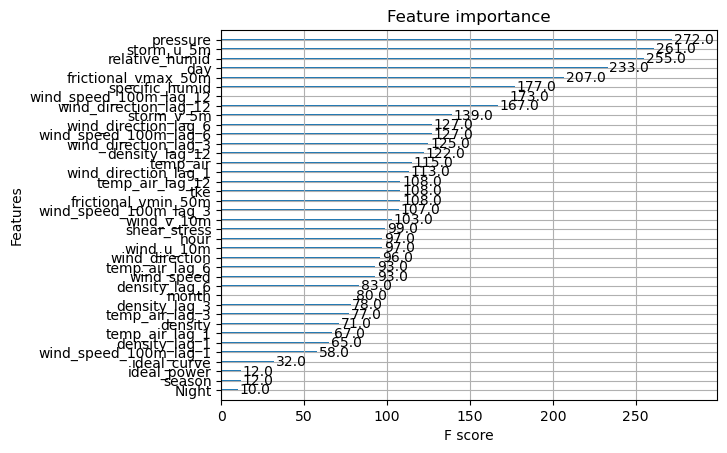

In [5]:
xgb.plot_importance(model)

In [29]:
y_pred * 0.26

array([4571.293 , 5521.002 , 5397.6025, ..., 2274.6636, 2219.0186,
       2946.0188], dtype=float32)

In [28]:
y_test

8760     6013.671875
8761     2556.640625
8762     2814.453125
8763     4181.640625
8764     3121.093750
            ...     
17514    3261.718750
17515    2259.765625
17516    3611.328125
17517    7109.375000
17518    8054.687500
Name: energy_kwh, Length: 8759, dtype: float64

In [32]:
NMAE(y_test, y_test)

22.936134220536726